## 신경망 학습

In [4]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

In [5]:
def cross_entropy_error(y ,t ):
    delta = 1e-7
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t* np.log(y + delta))/ batch_size

* 신경망에서의 기울기

In [6]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

* Softmax

In [7]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

* Sigmoid

In [8]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

* 2층 신경망 구현하기

In [9]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        # 예측 구하기 (가중치의 합 -> 시그모이드 통과 -> 가중치의 합 -> 소프트맥스 통과)
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)

        a2 = np.dot(z1, W2) + b2              
        y = softmax(a2)
        
        return y
        
    def loss(self, x, t):
        # 손실(비용) 함수의 결과 구하기
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        # 그레디언트(편미분의 벡터) 구하기
        loss_W = lambda W : self.loss(x, t)
        
        grads= {}
        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t): #물어볼 곳.
        W1 = self.params['W1']
        W2 = self.params['W2']
        b1 = self.params['b1']
        b2 = self.params['b2']
        
        batch_size = x.shape[0]
        grads = {}
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        da2 = (y-t) /batch_size
        grads['W2'] = np.dot(z1.T, da2)
        grads['b2'] = np.sum(da2, axis=0)
        
        dz1 = np.dot(da2, W2.T)
        da1 = ((1-z1)*z1) * dz1
        
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
       
        return grads
    

In [10]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼 파라미터
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1


train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] = network.params[key] - (learning_rate * grad[key])

        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    #print(i, loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09913333333333334, 0.1009
train acc, test acc | 0.7781666666666667, 0.7836
train acc, test acc | 0.8747, 0.8794
train acc, test acc | 0.8979666666666667, 0.9005
train acc, test acc | 0.90795, 0.9104
train acc, test acc | 0.9142666666666667, 0.9165
train acc, test acc | 0.91885, 0.92
train acc, test acc | 0.9225, 0.9247
train acc, test acc | 0.9263666666666667, 0.9281
train acc, test acc | 0.9296833333333333, 0.9321
train acc, test acc | 0.9329, 0.9326
train acc, test acc | 0.9349, 0.9359
train acc, test acc | 0.9377, 0.9379
train acc, test acc | 0.9397166666666666, 0.9396
train acc, test acc | 0.9425, 0.9419
train acc, test acc | 0.944, 0.9425
train acc, test acc | 0.94605, 0.944


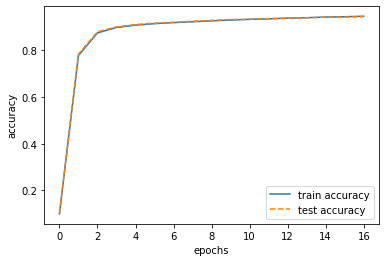

In [20]:
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label="train accuracy")
plt.plot(x, test_acc_list, label = "test accuracy", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="lower right")

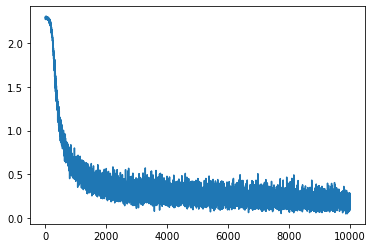

In [23]:
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)

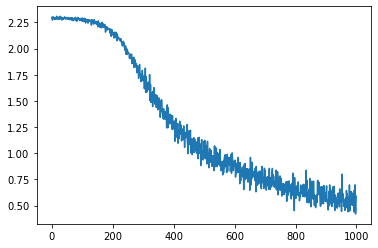

In [24]:
x = np.arange(len(train_loss_list)-9000)
plt.plot(x, train_loss_list[:1000])

지수 가중 평균법

In [1]:
 ! conda install tensorflow

^C
